In [57]:
import numpy as np 
import cmocean
import cmocean.cm as cmo
import xarray as xr   
from pathlib import Path
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import datetime 
from datetime import date 
import mpl_toolkits.basemap as bm
import matplotlib.animation as animation
import numpy.ma as ma
import matplotlib.cm as cm
from matplotlib.patches import Polygon
from scipy import signal, stats
import time
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
import warnings; warnings.simplefilter('ignore')

from functions import load_ice, trend, find_trends, plot_cartopy, decomp

# input data directory

path = Path('/extra-space1/data/tikoralukupload/cis-weekly/nc/')

# 2021
path2021 = Path('/extra-space1/data/tikoralukupload/cis-weekly/nc-for-May-2021-06-02')

# region of interest
region = 'HB'

# Projection for mapping
rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

# Construct the full file name
fname = path / '{}.nc'.format(region)
fname2021 = path2021 / '{}.nc'.format(region) # 2021

### Load data into a `xarray.Dataset`:
# Note that the data is loaded lazily which means that no actual data are actually written
# into memory.
# ds = xr.open_dataset(fname, decode_times=False)
# ds2021 = xr.open_dataset(fname2021, decode_times=False)

ds = xr.open_dataset(fname)
ds2021 = xr.open_dataset(fname2021)

juld = ds.juld
juld2021 = ds2021.juld
# Combine data structures
juld = xr.concat([juld, juld2021], "juld")

# subset `xarray.Dataset` by index -- Labrador shelf only
ds = ds.isel(x=slice(1700, None), y=slice(600, 1450))
ds2021 = ds2021.isel(x=slice(1700, None), y=slice(600, 1450))

# create shortcuts to the variables. 
lon = ds.longitude
lat = ds.latitude
land = ds.land
# E_FA = ds['E_FA']

E_SAold = ds['E_SA']
E_SA2021 = ds2021['E_SA']

E_SA = xr.concat([E_SAold, E_SA2021], dim="juld")


## Use N_CT for concentration 
N_CTold = ds['N_CT']
N_CT2021 = ds2021['N_CT']

N_CT = xr.concat([N_CTold, N_CT2021], dim="juld")


In [64]:
# Replace eggcode values for thickness with real values
A = xr.where(E_SA==1, 0.05, E_SA)
B = xr.where(E_SA==4, 0.125, A)
C = xr.where(E_SA==5, 0.225, B)
D = xr.where(E_SA==7, 0.50, C)
E = xr.where(E_SA==10, 0.95, D)
F = xr.where(E_SA==11, 1.60, E)
G = xr.where(E_SA==12, 2.50, F)
HA = xr.where(E_SA>13, np.nan, G)

In [58]:
# Replace eggcode values for concentration with real values
A = xr.where(N_CT>9, N_CT, N_CT/10)
B = xr.where(N_CT==10, 0.95, A)
CT = xr.where(N_CT==11, 1, B)
# Extract unique years
years = juld.dt.year
years_unique = np.unique(years)

## Average yearly ice thickness

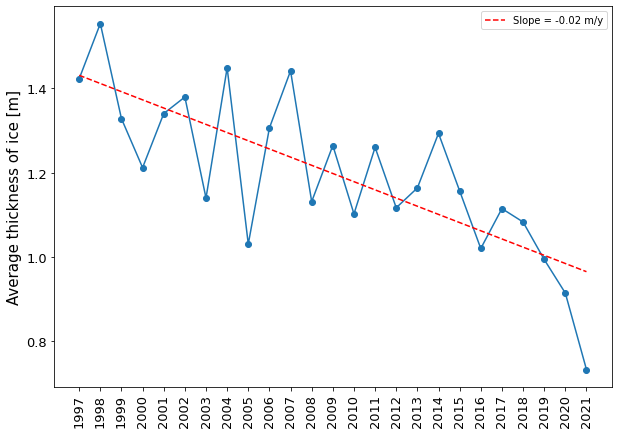

In [83]:
# Loop over all years and sum up thicknesses then take average
cnt=0
ice_thickness_mean = np.zeros(len(years_unique))
# Define ice season start as sept-sept
HA_yearly = HA.resample(juld="AS-SEP")
for yr in list(HA_yearly):
    # Check if list is not empty
    if np.sum(yr[1]) >= 1:
        # Area of ice average over number of data days
        ice_thickness_mean[cnt] = np.nanmean(yr[1])
        cnt +=1            

# Trend
s,b = np.polyfit(years_unique, ice_thickness_mean,1)

# Plot area mean

fig = plt.figure(figsize=(10,7), facecolor='white')

plt.plot(years_unique, ice_thickness_mean, 'ko-')
plt.xticks(years_unique,rotation='vertical', fontsize=13)
plt.plot(years_unique, s*years_unique + b, 'r--', label='Slope = %.2f m/y' %s)
plt.yticks(fontsize=13)
plt.ylabel('Average thickness of ice [m]', fontsize=15)
plt.legend()
# plt.savefig('/home/mwang/CIS/figures/Aug24_area_mean_sep.png', dpi=200)

# Average yearly ice area

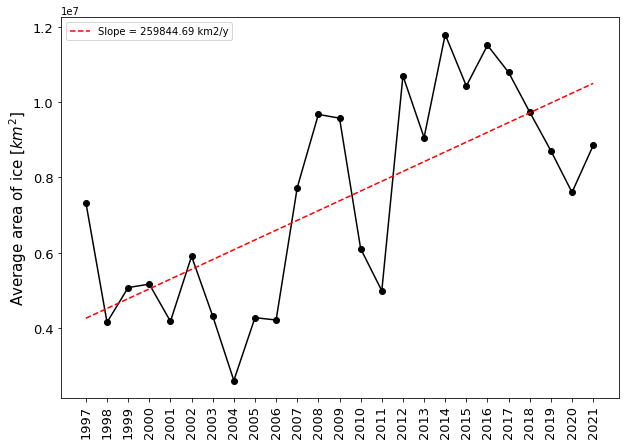

In [86]:
# Loop over all years and sum up concentrations (in tenths)
cnt=0
ice_area_mean = np.zeros(len(years_unique))
# Define ice season start as sept-sept
CT_yearly = CT.resample(juld="AS-SEP")
for yr in list(CT_yearly):
    # Check if list is not empty
    if np.sum(yr[1]) >= 1:
        # Area of ice average over number of data days
        ice_area_mean[cnt] = yr[1].sum()/len(yr[1])
        cnt +=1            

# Trend
s,b = np.polyfit(years_unique, ice_area_mean,1)

# Plot area mean

fig = plt.figure(figsize=(10,7), facecolor='white')

plt.plot(years_unique, ice_area_mean, 'ko-')
plt.xticks(years_unique,rotation='vertical', fontsize=13)
plt.plot(years_unique, s*years_unique + b, 'r--', label='Slope = %.2f km2/y' %s)
plt.yticks(fontsize=13)
plt.ylabel(r'Average area of ice [$km^2$]', fontsize=15)
plt.legend()
# plt.savefig('/home/mwang/CIS/figures/Aug24_area_mean_sep.png', dpi=200)

In [89]:
np.mean(ice_thickness_mean)

1.1981462447846325

In [92]:
0.73/1.19

0.6134453781512605

In [90]:
ice_thickness_mean

array([1.42287731, 1.55364638, 1.32818058, 1.21200045, 1.34024607,
       1.37954543, 1.13992933, 1.44887055, 1.03065903, 1.30613148,
       1.44154346, 1.13150634, 1.26448851, 1.10240115, 1.26009302,
       1.11689281, 1.16388888, 1.29332217, 1.15687792, 1.02029942,
       1.11489036, 1.08314857, 0.99429088, 0.91458532, 0.73334071])